In [359]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [ ]:
# # --- Load your data ---
# X = np.loadtxt("../Addis2025_DEM/X_Abaya_DEM.txt")
# Y = np.loadtxt("../Addis2025_DEM/Y_Abaya_DEM.txt")
# Z = np.loadtxt("../Addis2025_DEM/Abaya_DEM.txt")

# xb = np.loadtxt("../Addis2025_DEM/X_Abaya_catchment_boundary_try.txt")
# yb = np.loadtxt("../Addis2025_DEM/Y_Abaya_catchment_boundary_try.txt")

# --- Load your data ---
X = np.loadtxt("Addis2025_DEM/X_Abaya_DEM.txt")
Y = np.loadtxt("Addis2025_DEM/Y_Abaya_DEM.txt")
Z = np.loadtxt("Addis2025_DEM/Abaya_DEM.txt")
xb = np.loadtxt("Addis2025_DEM/X_Abaya_catchment_boundary_try.txt")
yb = np.loadtxt("Addis2025_DEM/Y_Abaya_catchment_boundary_try.txt")

In [ ]:
def compute_slopes_in_percentage(X, Y, Z):
    # Compute grid spacing
    dx = np.mean(np.diff(X, axis=1))
    dy = np.mean(np.diff(Y, axis=0))

    # Cardinal direction slopes
    dZdy, dZdx = np.gradient(Z, dy, dx)

    # Diagonal spacing
    diag_dist = np.sqrt(dx**2 + dy**2)

    # Diagonal derivatives
    dZd_NE = np.zeros_like(Z)
    dZd_NW = np.zeros_like(Z)

    dZd_NE[1:-1, 1:-1] = (Z[2:, 2:] - Z[:-2, :-2]) / (2 * diag_dist)
    dZd_NW[1:-1, 1:-1] = (Z[2:, :-2] - Z[:-2, 2:]) / (2 * diag_dist)

    # Convert slope (rise/run) to 0–1 percentage
    def slope_to_percentage(s):
        return np.abs(s) / (1 + np.abs(s))

    # Convert each direction
    sx = slope_to_percentage(dZdx)
    sy = slope_to_percentage(dZdy)
    sNE = slope_to_percentage(dZd_NE)
    sNW = slope_to_percentage(dZd_NW)

    # Take maximum slope per cell
    slope = np.maximum.reduce([sx, sy, sNE, sNW])

    return slope


def create_water_mask(slope):
    water_mask_1 = slope == 0.0
    water_mask_2 = Y < 0.75e6
    water_mask = water_mask_1 * water_mask_2
    return water_mask


def create_catchment_area_mask(X, Y, xb, yb):
    # Create mask
    boundary_polygon = Path(np.column_stack([xb, yb]))
    points = np.column_stack([X.ravel(), Y.ravel()])
    mask_flat = boundary_polygon.contains_points(points)
    mask = mask_flat.reshape(X.shape)
    return mask


slope = compute_slopes_in_percentage(X, Y, Z)
water_mask = create_water_mask(slope)
cachment_area_mask = create_catchment_area_mask(X, Y, xb, yb)


In [347]:
def plot_field(X, Y, vals, title: str = ""):
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # DEM plot
    im0 = ax.imshow(
        vals, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap="terrain"
    )
    # ax.set_title(title)
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    fig.colorbar(im0, ax=ax, label=title)
    plt.show()

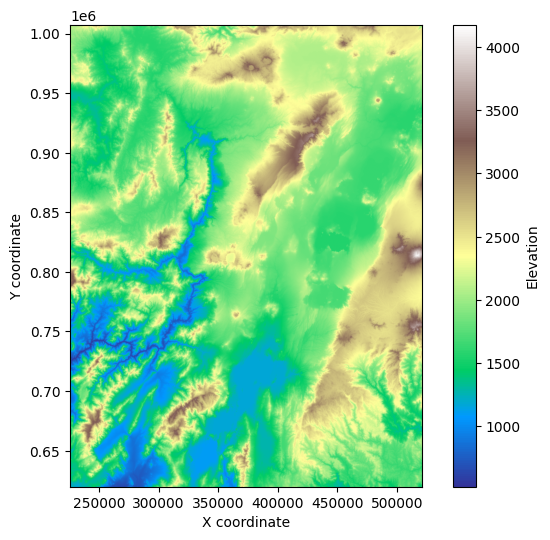

In [348]:
plot_field(X, Y, Z, "Elevation")

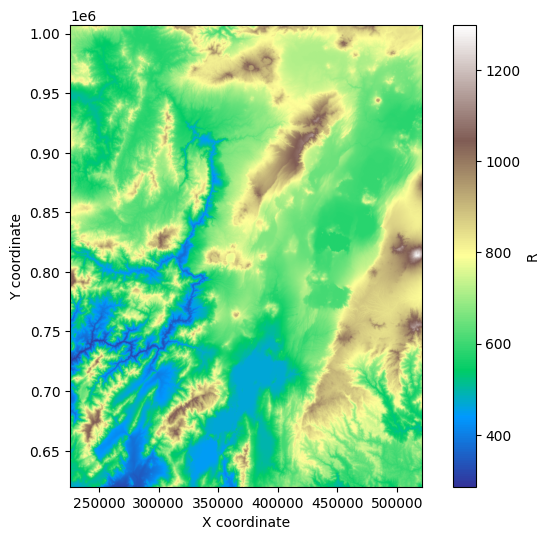

In [349]:
precip_mat = 266.21 + 0.493 * Z
R = -8.12 + 0.562 * precip_mat
plot_field(X, Y, R, "R")

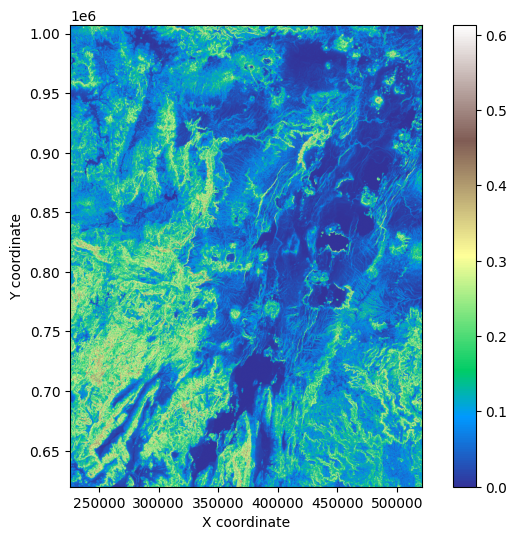

In [350]:
plot_field(X, Y, slope)

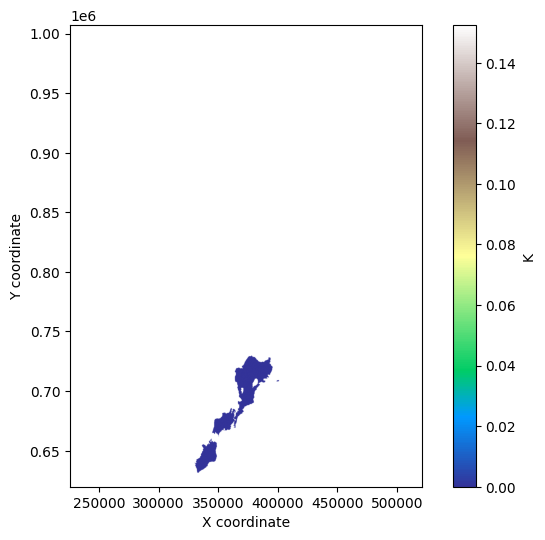

In [351]:
K = np.ones_like(Z) * 0.1525
K[water_mask] = 0.0
plot_field(X, Y, K, "K")

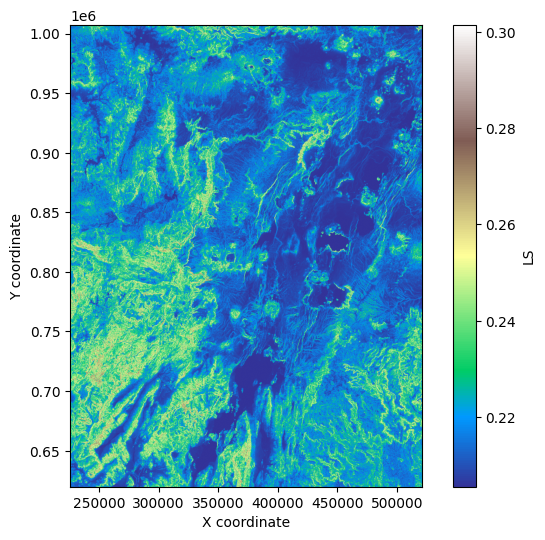

In [352]:
dx = np.mean(np.diff(X, axis=1))
dy = np.mean(np.diff(Y, axis=0))
slope_length = np.sqrt(dx**2 + dy**2)
LS = (0.065 + 0.0456 * slope + 0.006541 * (slope**2)) * (slope_length / 22.1) ** 0.5
plot_field(X, Y, LS, "LS")

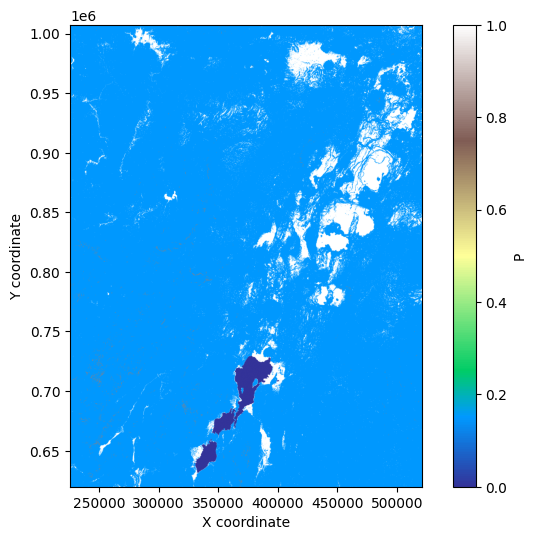

In [ ]:
# P = np.ones_like(Z) * 1
# P[water_mask] = 0.0


def create_P(Z, slope):
    P = np.ones_like(Z)

    binned_values = [
        0.15,  # Crops
        0.15,  # Crops
        0.8,  # Bare land
    ]

    # ---- Binning into 10 bins ----
    num_bins = 3
    bins = np.linspace(slope.min() + 0.01, slope.max(), num_bins + 1)
    binned_slopes = np.digitize(slope, bins) - 1  # subtract 1 so bins go 0..9

    for i in range(len(binned_values)):
        P[binned_slopes == i] = binned_values[i]

    P[water_mask] = 0.0
    return P


P = create_P(Z, slope)

plot_field(X, Y, P, "P")

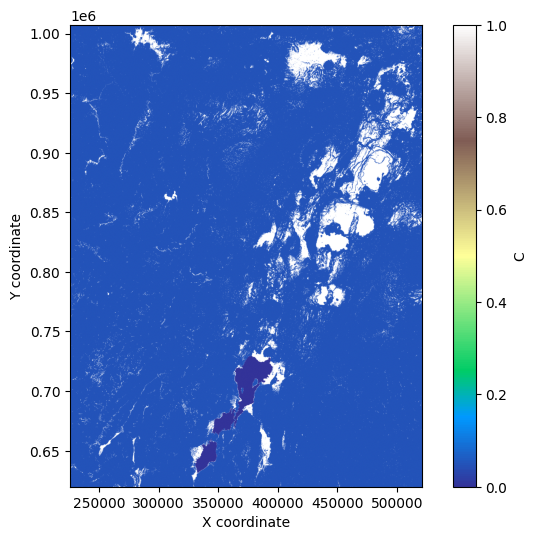

In [397]:
def create_C(Z, slope):
    C = np.ones_like(Z)

    binned_values = [
        0.05,  # Crops
        # 0.15,  # Crops
        0.05,  # Trees
        1,  # Bare land
    ]

    # ---- Binning into 10 bins ----
    num_bins = 3
    bins = np.linspace(slope.min() + 0.01, slope.max(), num_bins + 1)
    binned_slopes = np.digitize(slope, bins) - 1  # subtract 1 so bins go 0..9

    for i in range(len(binned_values)):
        C[binned_slopes == i] = binned_values[i]

    C[water_mask] = 0.0
    return C


C = create_C(Z, slope)
plot_field(X, Y, C, "C")

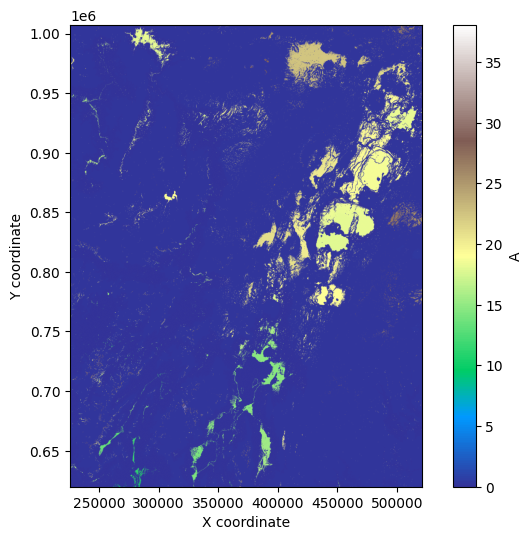

In [398]:
A = R * K * LS * C * P
plot_field(X, Y, A, "A")

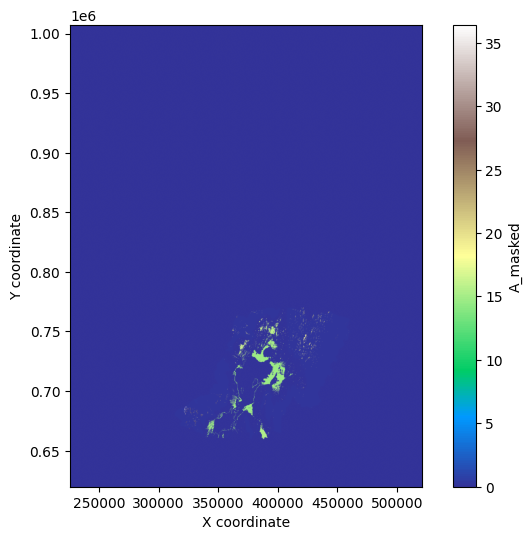

In [399]:
A_masked = A * cachment_area_mask
plot_field(X, Y, A_masked, "A_masked")

In [400]:
area = 1140e6
depth = 8.61
volume_rough_estimate = area * depth
volume = 16449907114  # Dir-BCs
# volume = 28417605424 # N-BCs
volume = 13456716598

print(f"Volume: {volume_rough_estimate}")
print(f"Volume improved estimate: {volume}")

Volume: 9815400000.0
Volume improved estimate: 13456716598


In [401]:
cachment_area = np.sum(np.ones_like(Z) * cachment_area_mask * water_mask * dx * dy)
print(f"Cachment area: {cachment_area}")

Cachment area: 1023560394.7766052


In [404]:
erosion_vol = np.sum(A_masked * 1e-4 * dx * dy) / (2.65 * 0.4)
time_until_filled = volume / erosion_vol
print(f"Estimated time until the lake is filled: {time_until_filled:.2f} years")

Estimated time until the lake is filled: 12574.20 years
